**MC-LSTM**

In [2]:
## Run this so that the Orgonal Code can pull and clone the Github repository and install it
!git clone https://github.com/zexyang/RUL_prediction_ME599.git
%cd RUL_prediction_ME599
!cat README.md

Cloning into 'RUL_prediction_ME599'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 51 (delta 13), reused 28 (delta 8), pack-reused 18
Receiving objects: 100% (51/51), 57.80 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (22/22), done.
/content/RUL_prediction_ME599
# A Hybrid CNN-LSTM for Battery Remaining Useful Life Prediction with Charging Profiles Data
[![DOI:10.1145/3575882.3575903](http://img.shields.io/badge/DOI-10.1145/3575882.3575903-1481c1.svg)](https://doi.org/10.1145/3575882.3575903)

+ Battery RUL prediction using data-driven method based on a hybrid deep model of Convolutional Neural Networks (CNN) and Long-Short Term Memory (LSTM).
+ CNN and LSTM are used to extract features from multiple measurable data (Voltage, Current, Temperature, Capacity) in parallel.
+ CNN extracts features of multi-channel charging profiles, whereas LSTM ext


Fold 1
Input shape: (326, 5, 31)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 400)            691200    
                                                                 
 dropout_6 (Dropout)         (None, 5, 400)            0         
                                                                 
 flatten_3 (Flatten)         (None, 2000)              0         
                                                                 
 dense_12 (Dense)            (None, 400)               800400    
                                                                 
 dense_13 (Dense)            (None, 1)                 401       
                                                                 
Total params: 1492001 (5.69 MB)
Trainable params: 1492001 (5.69 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________

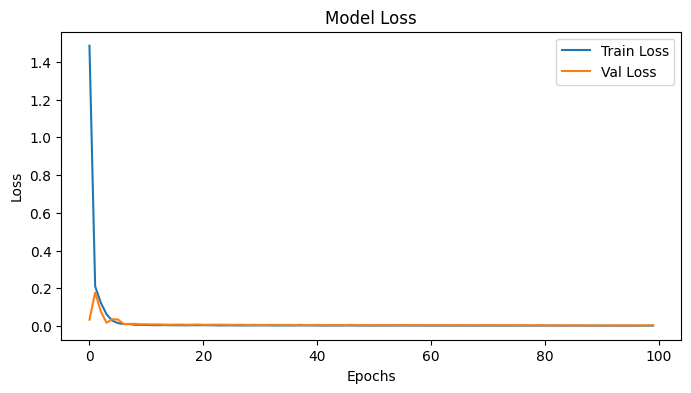

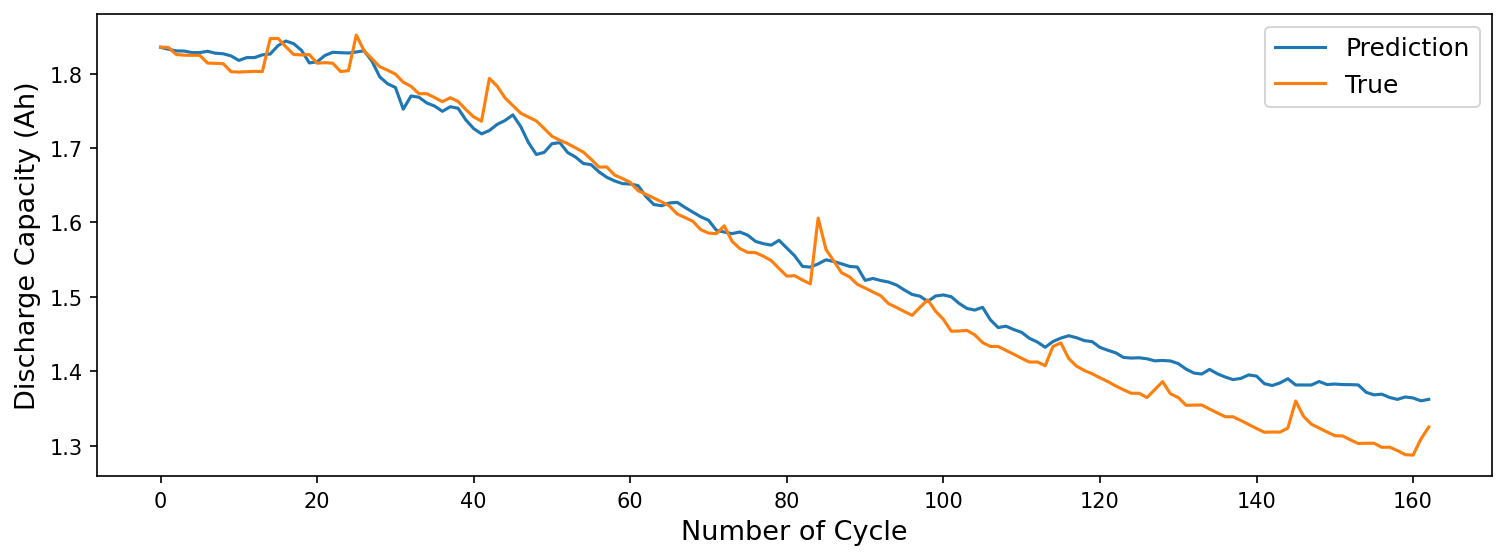

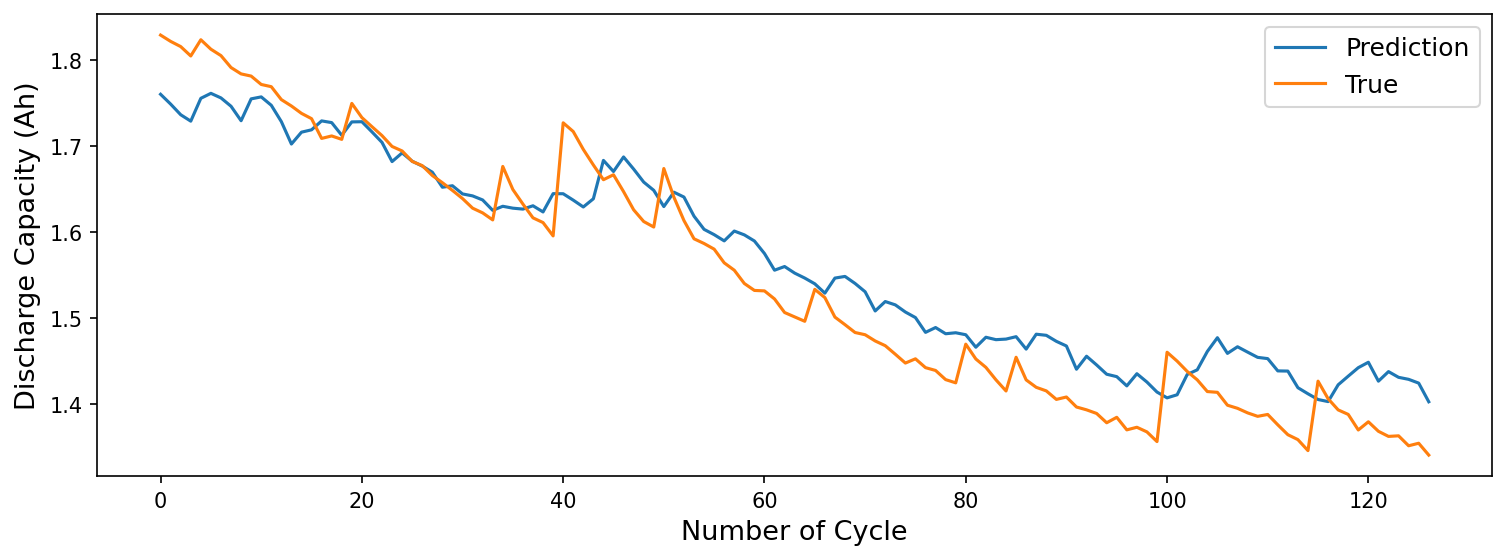

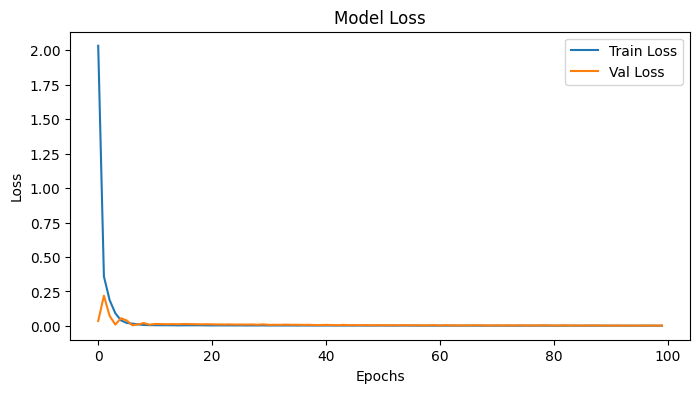

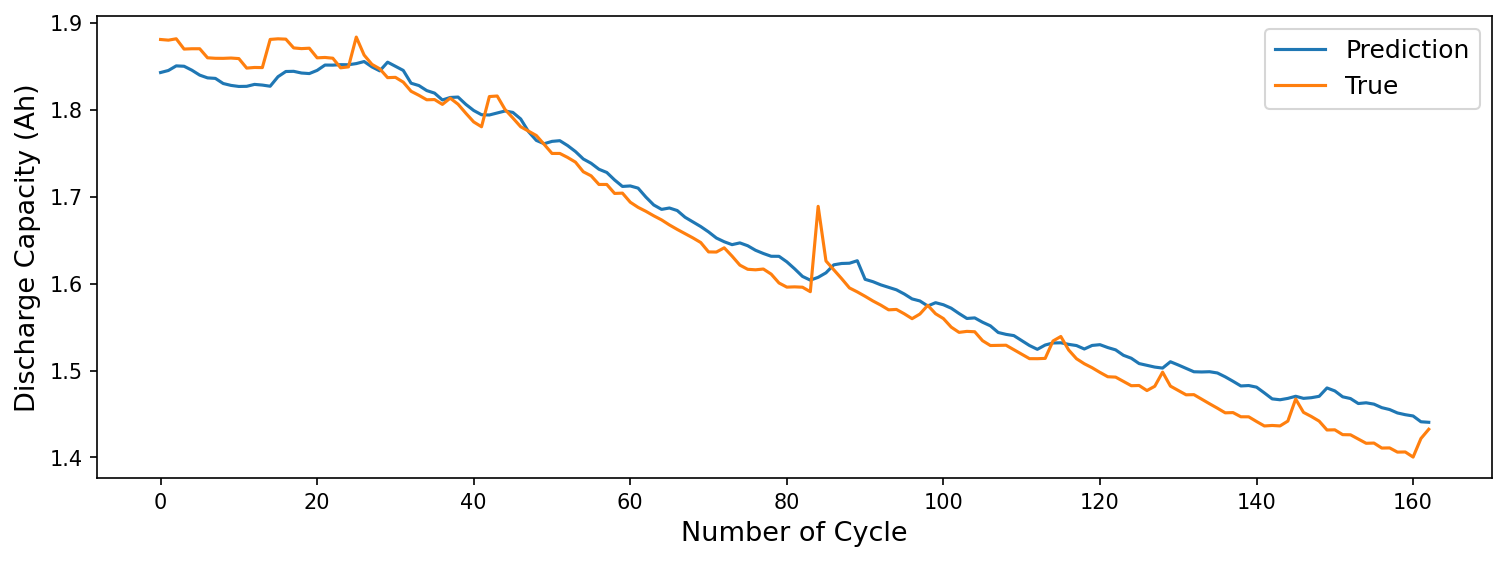

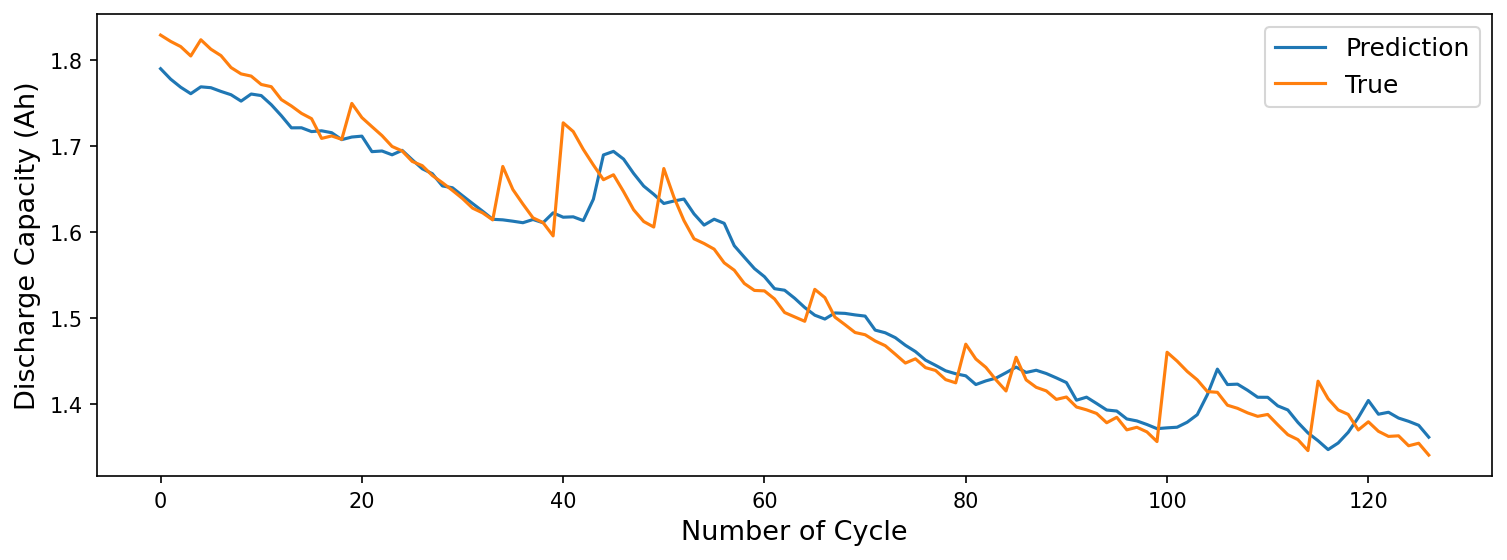

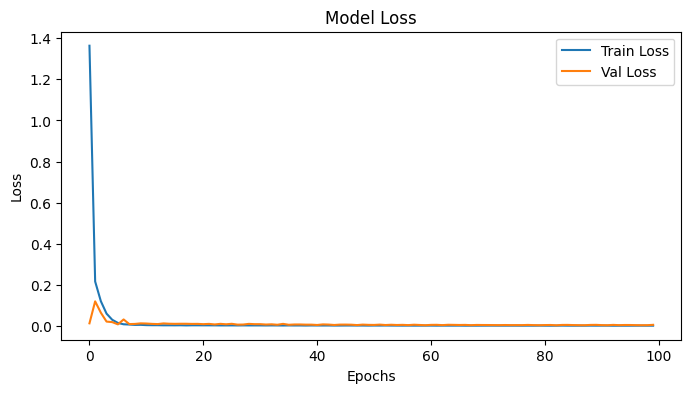

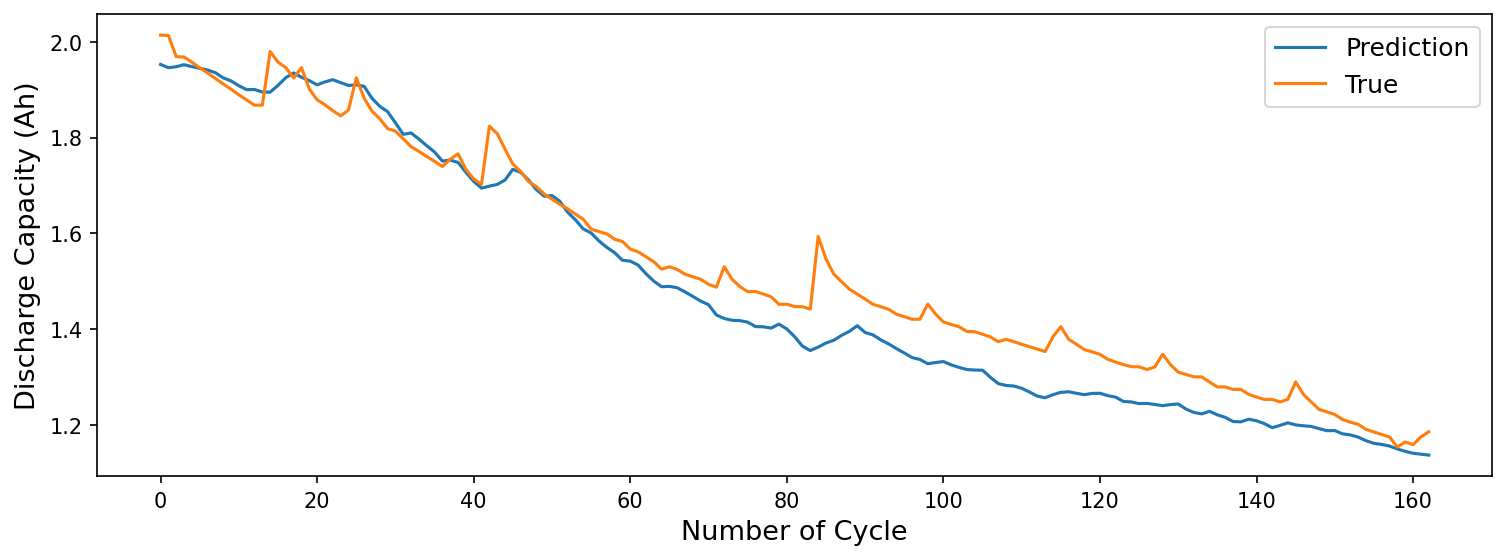

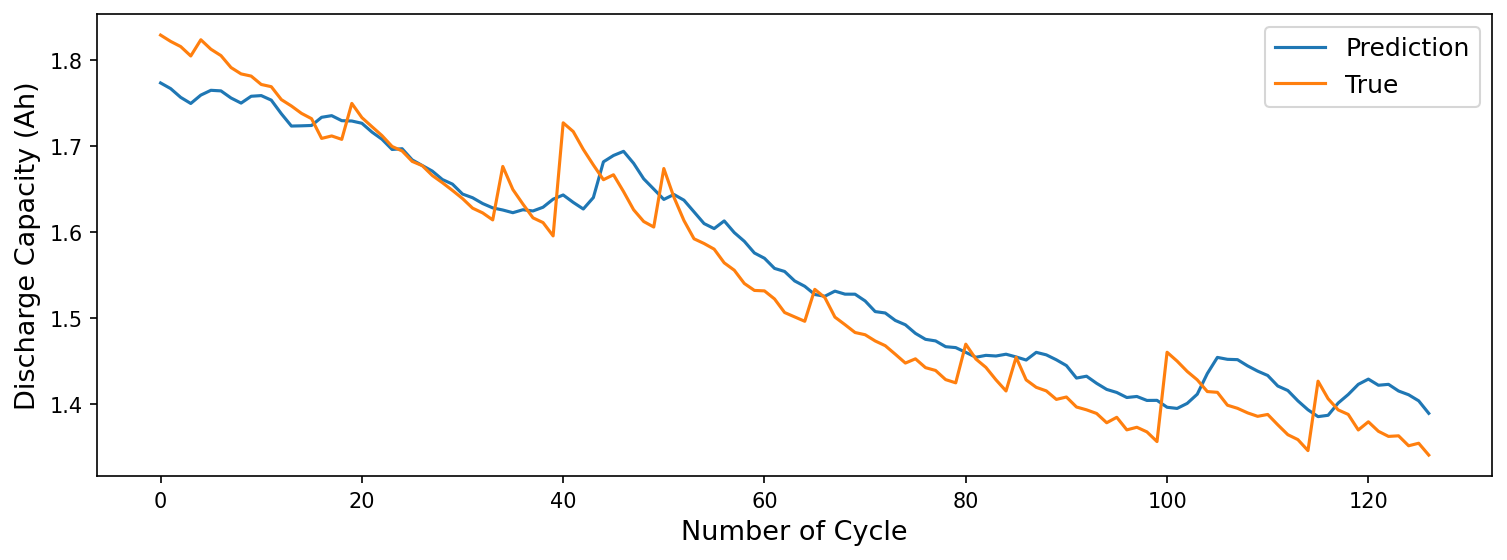

In [5]:
import random as rn
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import json
import re

# Set seeds for reproducibility
SEED = 12345
os.environ["CUDA_VISIBLE_DEVICES"] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
tf.compat.v1.random.set_random_seed(SEED)
tf.random.set_seed(SEED)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Define preprocessing function
def preprocess(dataset):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(dataset)
    return scaled, scaler

# Define function to extract VIT capacity
def extract_VIT_capacity(x_datasets, y_datasets, seq_len, hop, sample):
    from pandas import read_csv, DataFrame
    V, I, T, C = [], [], [], []
    x, y = [], []

    for x_data, y_data in zip(x_datasets, y_datasets):
        x_df = read_csv(x_data).dropna()[['cycle', 'voltage_battery', 'current_battery', 'temp_battery']]
        x_df = x_df[x_df['cycle'] != 0].reset_index(drop=True)

        y_df = read_csv(y_data).dropna()[['capacity']]
        y_df['cycle_idx'] = y_df.index + 1
        y_df = y_df.astype('float32').values

        data_len = int(np.floor((len(y_df) - seq_len - 1) / hop)) + 1

        for i in range(len(y_df)):
            cy = x_df.cycle.unique()[i]
            df = x_df[x_df['cycle'] == cy]
            cap = np.array([y_df[i, 0]])
            C.append(cap)
            scaled_C, scaler_C = preprocess(np.array(C))
            le = len(df['voltage_battery']) % sample

            vTemp = df['voltage_battery'].to_numpy()
            if le != 0:
                vTemp = vTemp[0:-le]
            vTemp = np.reshape(vTemp, (len(vTemp) // sample, -1), order="F").mean(axis=0)
            V.append(vTemp)
            scaled_V, _ = preprocess(np.array(V))

            iTemp = df['current_battery'].to_numpy()
            if le != 0:
                iTemp = iTemp[0:-le]
            iTemp = np.reshape(iTemp, (len(iTemp) // sample, -1), order="F").mean(axis=0)
            I.append(iTemp)
            scaled_I, _ = preprocess(np.array(I))

            tTemp = df['temp_battery'].to_numpy()
            if le != 0:
                tTemp = tTemp[0:-le]
            tTemp = np.reshape(tTemp, (len(tTemp) // sample, -1), order="F").mean(axis=0)
            T.append(tTemp)
            scaled_T, _ = preprocess(np.array(T))

            VIT_temp = np.concatenate([scaled_V, scaled_I, scaled_T, scaled_C], axis=1)

        for i in range(data_len):
            x.append(VIT_temp[(hop * i):(hop * i + seq_len)])
            y.append(scaled_C[hop * i + seq_len])

    return np.array(x), np.array(y), scaler_C

# Define main function
def main():
    import RUL_prediction_ME599.train.param_VITC_C as pr
    import RUL_prediction_ME599.train.utils as utils

    pth = pr.pth
    train_x_files = [os.path.join(pth, 'charge/train', f) for f in os.listdir(os.path.join(pth, 'charge/train'))]
    train_x_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    train_y_files = [os.path.join(pth, 'discharge/train', f) for f in os.listdir(os.path.join(pth, 'discharge/train'))]
    train_y_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    test_x_data = [os.path.join(pth, 'charge/test', f) for f in os.listdir(os.path.join(pth, 'charge/test'))]
    test_y_data = [os.path.join(pth, 'discharge/test', f) for f in os.listdir(os.path.join(pth, 'discharge/test'))]

    folds = list(KFold(n_splits=pr.k, shuffle=True, random_state=pr.random).split(train_x_files))

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nFold', j + 1)
        train_x_data = [train_x_files[i] for i in train_idx]
        train_y_data = [train_y_files[i] for i in train_idx]
        val_x_data = [train_x_files[i] for i in val_idx]
        val_y_data = [train_y_files[i] for i in val_idx]

        trainX, trainY, SS_tr = extract_VIT_capacity(train_x_data, train_y_data, pr.seq_len, pr.hop, pr.sample)
        valX, valY, SS_val = extract_VIT_capacity(val_x_data, val_y_data, pr.seq_len, pr.hop, pr.sample)
        testX, testY, SS_tt = extract_VIT_capacity(test_x_data, test_y_data, pr.seq_len, pr.hop, pr.sample)

        print('Input shape: {}'.format(trainX.shape))

        model = Sequential([
            LSTM(400, input_shape=(pr.seq_len, trainX.shape[-1]), activation='tanh', return_sequences=True),
            Dropout(0.5),
            Flatten(),
            Dense(400),
            Dense(1)
        ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        model.summary()

        history = model.fit(trainX, trainY, validation_data=(valX, valY), batch_size=pr.batch_size, epochs=pr.epochs)

        save_dir = pr.save_dir
        os.makedirs(save_dir, exist_ok=True)
        model_dir = pr.model_dir + '_k' + str(j + 1)
        os.makedirs(os.path.join(save_dir, model_dir), exist_ok=True)

        model.save(os.path.join(save_dir, model_dir, "saved_model_and_weight"))
        print("Model and weights saved.")

        val_results = model.evaluate(valX, valY)
        print('Val loss:', val_results)

        test_results = model.evaluate(testX, testY)
        print('Test loss:', test_results)

        valPredict = model.predict(valX)
        testPredict = model.predict(testX)

        inv_valY = SS_val.inverse_transform(valY)
        inv_valPredict = SS_val.inverse_transform(valPredict)
        inv_testY = SS_tt.inverse_transform(testY)
        inv_testPredict = SS_tt.inverse_transform(testPredict)

        test_mae = mean_absolute_error(inv_testY, inv_testPredict)
        test_mse = mean_squared_error(inv_testY, inv_testPredict)
        test_mape = mean_absolute_percentage_error(inv_testY, inv_testPredict)
        test_rmse = np.sqrt(mean_squared_error(inv_testY, inv_testPredict))

        print(f'Test MAE: {test_mae}')
        print(f'Test MSE: {test_mse}')
        print(f'Test MAPE: {test_mape}')
        print(f'Test RMSE: {test_rmse}')

        with open(os.path.join(save_dir, model_dir, 'eval_metrics.txt'), 'w') as f:
            f.write(f'Train data: {json.dumps(train_x_data)}\n')
            f.write(f'Val data: {json.dumps(val_x_data)}\n')
            f.write(f'Test data: {json.dumps(test_x_data)}\n')
            f.write(f'Test MAE: {test_mae}\n')
            f.write(f'Test MSE: {test_mse}\n')
            f.write(f'Test MAPE: {test_mape}\n')
            f.write(f'Test RMSE: {test_rmse}\n')

        np.savetxt(os.path.join(save_dir, model_dir, 'test_predict.txt'), inv_testPredict)
        np.savetxt(os.path.join(save_dir, model_dir, 'test_true.txt'), inv_testY)

        utils.plot_loss(history, save_dir, model_dir)
        utils.plot_pred(inv_valPredict, inv_valY, save_dir, model_dir, "val_pred")
        utils.plot_pred(inv_testPredict, inv_testY, save_dir, model_dir, "test_pred")

if __name__ == "__main__":
    main()